# Factorisation d'entiers en le transformant dans le modèle QUBO (ou d'Ising)

Présentation générale de l'idée en quelques lignes

In [1]:
import sympy as sp
import numpy as np
import math
from pprint import *

#### variables globales
1. variables : une liste contient des symboles créés; utilisé dans la partie expressions
2. dictionaire_auxiliary_variable : des variables créées pour remplacer le produit de deux variables dans p et q
3. res : number , pour créer le nom des variables
4. variables_Ising : variables dans Hamiltonain expresstion
5. dict_variables_binary : map variables dans hamiltonian et variables dans modèle

In [2]:
variables=[]
dictionaire_auxiliary_variable={}
res=1
variables_Ising =[]
dict_variable_model_map={}

# Expression

## Step 0 : dénifir la fonction $f = (N-pq)^2$
On utilise `Sympy` pour travailler sur des expressions symboliques du calcul formel.
Dans le monde symbolique de `Sympy`, il faut définir des variables symboliques:

In [3]:
# Créer un symbole à partir d'un nom en string
def create_variables(var_name):
    if isinstance(var_name, str) :
        try:
            symbol = sp.symbols(var_name)
            globals()[var_name] = symbol
            variables.append(symbol)
        except ValueError:
            print(f"{var_name} ValueError")
    return symbol

### Définir les expressions symboliques pour les écritures de $p$ et $q$ en binaire.

On suppose $p$ et $q$ impairs (sinon la factorisation de $N$ serait triviale).

$p$ en binaire peut être représenté comme:

(pl1-1,..p1,1) = pl1-1 * 2 ** (l1-1) + ... + p1 * 2 **1 +1

$q$ en binaire peut être représenté comme:

(ql2-1,..,q1,1) = ql2-1 * 2 ** (l2-1) + ... + q1 * 2 **1 +1

Avec $l1=\lfloor\log_2(p)\rfloor$ et $l2 =\lfloor\log_2(q)\rfloor$

In [4]:
def set_variable(l1,l2):
    #p
    expr_p = 1
    for i in range(1,l1):
        var_name = ('p'+ str(i))
        var = create_variables(var_name)
        expr_p = 2**i * var + expr_p 
    #q
    expr_q = 1
    for i in range(1,l2):
        var_name = ('q'+ str(i))
        var = create_variables(var_name)
        expr_q = 2**i * var + expr_q
    return (expr_p,expr_q)

In [5]:
(p,q) = set_variable(3,3)
print(p,q)

2*p1 + 4*p2 + 1 2*q1 + 4*q2 + 1


### Définir l'expression symbolique $(N-p*q)^2$

Le min de cette expression dans $\mathbb{Z}$ est $0$, dans ce cas $N = p*q$.

In [6]:
def define_function(N,p,q):
    expr_pq = p *q
    return (N - expr_pq)**2

**Exemple :** On définit l'expression symbolique pour $N=15$ avec $p=2*p_1 + 1$ et $q=2*q1 + 4*q2 + 1$

In [7]:
expr = define_function(35,p,q)
expr

(-(2*p1 + 4*p2 + 1)*(2*q1 + 4*q2 + 1) + 35)**2

On peut développer cette expression avec `sp.expand(expr)` .

On obtient l'expression suivante    
    $\displaystyle 16 p_{1}^{2} q_{1}^{2} + 64 p_{1}^{2} q_{1} q_{2} + 16 p_{1}^{2} q_{1} + 64 p_{1}^{2} q_{2}^{2} + 32 p_{1}^{2} q_{2} + 4 p_{1}^{2} + 16 p_{1} q_{1}^{2} + 64 p_{1} q_{1} q_{2} - 104 p_{1} q_{1} + 64 p_{1} q_{2}^{2} - 208 p_{1} q_{2} - 56 p_{1} + 4 q_{1}^{2} + 16 q_{1} q_{2} - 56 q_{1} + 16 q_{2}^{2} - 112 q_{2} + 196$


## Step 1: Réduire les puissances dans l'expression

L'expression obtenue avant peut être simplifiée: la puissance de toutes les variables est égale à 1.

$p_1^2 = p_1$, car $1 * 1 = 1$ et $0 * 0 = 0$

In [8]:
def reduct_variable_power_term(term):
    new_term = 1
    for variable,power in term.as_powers_dict().items():
        new_term *= variable
    return new_term

def reduct_variable_power_function(expr):
    expanded_expr = sp.expand(expr)
    expanded_reducted = 0
    for term in expanded_expr.args:
        new_term = reduct_variable_power_term(term)
        expanded_reducted += new_term
    return expanded_reducted


**exemple (suite):** En utilisant l'expression définie avant on obtient:

In [9]:
expr_reduct_power = reduct_variable_power_function(expr)
expr_reduct_power

256*p1*p2*q1*q2 + 128*p1*p2*q1 + 384*p1*p2*q2 + 16*p1*p2 + 128*p1*q1*q2 - 216*p1*q1 - 368*p1*q2 - 132*p1 + 384*p2*q1*q2 - 368*p2*q1 - 544*p2*q2 - 256*p2 + 16*q1*q2 - 132*q1 - 256*q2 + 1156

## Step 2: Réduire les termes pour qu'ils ne fassent jamais intervenir plus de deux variables

In [10]:
# les varaiables sont sort par la lettre puis un nombre: "x12" -> "x" 12
def sort_key(variable):
    name = str(variable)
    # Split le nom du variable aux deux parties: letter & number 
    letter = name[0]
    number = int(name[1:])
    return (letter, number)

### Réduction degrée formule

In [11]:
# Pour chaque terme compose de >= 3 variables, 
# Les 3 première variables devrait participer dans la réduction
# Les autres variables et le coef construit terme qui est terme resté
# Un nouveau terme : mulp (réduction, teme resté)
def build_rest_term(coef , rest_variable_liste):
    new_term = coef
    while(len(rest_variable_liste)!=0):
        new_term = new_term * rest_variable_liste[0]
        rest_variable_liste.pop()
    return new_term

# si #variables > 2 : diemension -1
def reduct_demension_term(coef,variables_liste):    
    global res

    # sélection les 3 premières variables
    [x_1, x_2, x_3] = variables_liste[:3]
    
    # garder le reste des variables
    rest_variables_liste= variables_liste[3:]
    rest_term = build_rest_term(coef , rest_variables_liste)

    # commence la réduction dimension
    tup=(x_1,x_2)
    #check dict s'il existe déjà une variable auxiliary qui = les deux meme variable
    key = next((k for k, v in dictionaire_auxiliary_variable.items() if v == tup), None)

    if key==None:#sinon, il faut creer une variable auxiliary
        var_name = "x" + str(res)
        x_4 = create_variables(var_name)
        dictionaire_auxiliary_variable[x_4]=(x_1,x_2)
        res += 1 
    else:
        x_4 = key 

    reduct_formula = x_4 * x_3 + 2 * (x_1 * x_2 - 2 * x_1 * x_4 - 2 * x_2 * x_4 + 3 * x_4)
    reduct_formula = sp.expand(reduct_formula)

    # mulp
    expr_reduct = rest_term * reduct_formula
    return sp.expand(expr_reduct)


### Réduction procède

In [12]:
def reduct_demension_expression(expr):

    print("Original expr:", expr)
    new_expr = 0
    need_reduction = False

    for term in expr.args:
        # get coefficant(la constante) et variables(dans une liste)
        variables_liste = sorted(term.free_symbols, key=sort_key)
        coef = term.as_coeff_mul()[0]

        # pour les termes qui ont plus de 2 variables, il faut appliquer la formule de réduction
        if len(variables_liste) > 2 :
            need_reduction = True
            new_term = reduct_demension_term(coef, variables_liste) 
            new_expr +=  new_term
        else:
            # sinon, on ne fait rien et les met directement dans la nouvelle expression
            new_expr += term

    if need_reduction:
        print("Recursing with:", new_expr)
        return reduct_demension_expression(new_expr)
    else:
        print("Final expression:", new_expr)
        return new_expr

In [13]:
def reduct_demension_expression1(expr):
    print("Original expr:", expr)
    new_expr = 0

    for term in expr.args:
        # get coefficant(la constante) et variables(dans une liste)
        variables_liste = sorted(term.free_symbols, key=sort_key)
        coef = term.as_coeff_mul()[0]

        # pour les termes qui ont plus de 2 variables, il faut appliquer la formule de réduction
        if len(variables_liste) > 2 :
            new_term = reduct_demension_term(coef, variables_liste) 
            new_expr +=  new_term
        else:
            # sinon, on ne fait rien et les met directement dans la nouvelle expression
            new_expr += term

    if expr != new_expr : # récursive
        print('############')
        return reduct_demension_expression(new_expr)
        
    else:
        return new_expr

**Exemple (suite):** réduisons le nombre de variables utilisées dans chaque terme de l'expression simplifiée précédente:

In [14]:

reduct_demension_expr = reduct_demension_expression(expr_reduct_power)
pprint(reduct_demension_expr)

Original expr: 256*p1*p2*q1*q2 + 128*p1*p2*q1 + 384*p1*p2*q2 + 16*p1*p2 + 128*p1*q1*q2 - 216*p1*q1 - 368*p1*q2 - 132*p1 + 384*p2*q1*q2 - 368*p2*q1 - 544*p2*q2 - 256*p2 + 16*q1*q2 - 132*q1 - 256*q2 + 1156
Recursing with: 512*p1*p2*q2 + 1040*p1*p2 + 40*p1*q1 - 1024*p1*q2*x1 - 368*p1*q2 - 2048*p1*x1 - 512*p1*x2 - 132*p1 + 400*p2*q1 - 1024*p2*q2*x1 - 544*p2*q2 - 2048*p2*x1 - 1536*p2*x3 - 256*p2 + 256*q1*q2*x1 + 16*q1*q2 + 128*q1*x1 - 512*q1*x2 - 1536*q1*x3 - 132*q1 + 1920*q2*x1 + 128*q2*x2 + 384*q2*x3 - 256*q2 + 3072*x1 + 768*x2 + 2304*x3 + 1156
Original expr: 512*p1*p2*q2 + 1040*p1*p2 + 40*p1*q1 - 1024*p1*q2*x1 - 368*p1*q2 - 2048*p1*x1 - 512*p1*x2 - 132*p1 + 400*p2*q1 - 1024*p2*q2*x1 - 544*p2*q2 - 2048*p2*x1 - 1536*p2*x3 - 256*p2 + 256*q1*q2*x1 + 16*q1*q2 + 128*q1*x1 - 512*q1*x2 - 1536*q1*x3 - 132*q1 + 1920*q2*x1 + 128*q2*x2 + 384*q2*x3 - 256*q2 + 3072*x1 + 768*x2 + 2304*x3 + 1156
Recursing with: 2064*p1*p2 + 40*p1*q1 - 2416*p1*q2 - 4096*p1*x1 - 512*p1*x2 + 4096*p1*x4 - 132*p1 + 400*p2*q1

In [15]:
# obtient l'expression finale
def get_reduct_expression(N,p,q):
    expr = define_function(N,p,q)
    expr_reduct_power = reduct_variable_power_function(expr)
    reduct_demension_expr = reduct_demension_expression(expr_reduct_power)
    return reduct_demension_expr

In [16]:
# de reduct_demension_expr à reduct_variable_power_function
# pour vérifier
def detransfer_expr(reduct_demension_expr):
    dict_inverse = {valeur: cle for cle, valeur in dictionaire_auxiliary_variable.items()}
    new_expr = reduct_demension_expr.subs(dict_inverse)
    return sp.expand(new_expr)

In [17]:
detransfer_expr(reduct_demension_expr)

2064*p1*p2 + 40*p1*q1 - 2416*p1*q2 - 4096*p1*x1 - 512*p1*x2 + 4096*p1*x4 - 132*p1 + 400*p2*q1 - 2592*p2*q2 - 4096*p2*x1 - 1536*p2*x3 + 4096*p2*x5 - 256*p2 + 528*q1*q2 + 128*q1*x1 - 512*q1*x2 - 1536*q1*x3 - 1024*q1*x6 - 132*q1 + 2432*q2*x1 + 128*q2*x2 + 384*q2*x3 + 4096*q2*x4 + 4096*q2*x5 - 1024*q2*x6 - 256*q2 - 1024*x1*x4 - 1024*x1*x5 + 256*x1*x6 + 6144*x1 + 768*x2 + 2304*x3 - 6144*x4 - 6144*x5 + 1536*x6 + 1156

# Factorisation d'entiers en le transformant dans le modèle QUBO (ou d'Ising)

Cette expression est un problème d'optimisation binaire quadratique sans contrainte (QUBO) sur 4 variables ($p_1,q_1,q_2,x_1$) qui peut
être transformé en un hamiltonien d'Ising équivalent

On fait appel à la librairie [Dimod](https://test-projecttemplate-dimod.readthedocs.io/en/release_notes/introduction.html) qui permet de créer un modèle d'Ising à partir d'une expression mathématique donnée sous la forme symbolique.

## Step3: Transfer de Qubo à Ising 

De reduct_demension_expr, on remplace les variables du Qubo problème aux variables du Ising problème:

$\displaystyle variable_q \in \{0,1\} = (variable_i +1)/2$ avec $ variable_i \in \{-1,1\} $

In [18]:
def transfers_qubo2Ising(reduct_demension_expr):
    
    subs_relations = {(variable, ( variable + 1 ) /2) for variable in variables}
    
    # Après la substitution, variables dans l'expression sont des variables d'Ising dans {-1,+1}
    new_expr = reduct_demension_expr.subs(subs_relations)
    new_expr = sp.expand(new_expr)
    return new_expr

**Exemple (suite):** On transforme l'expression réduite précédente en une expression pour le modèle d'Ising qui pourra être transformé par la librairie

In [19]:
expr_ising = transfers_qubo2Ising(reduct_demension_expr)
expr_ising

516*p1*p2 + 10*p1*q1 - 604*p1*q2 - 1024*p1*x1 - 128*p1*x2 + 1024*p1*x4 - 272*p1 + 100*p2*q1 - 648*p2*q2 - 1024*p2*x1 - 384*p2*x3 + 1024*p2*x5 - 544*p2 + 132*q1*q2 + 32*q1*x1 - 128*q1*x2 - 384*q1*x3 - 256*q1*x6 - 560*q1 + 608*q2*x1 + 32*q2*x2 + 96*q2*x3 + 1024*q2*x4 + 1024*q2*x5 - 256*q2*x6 + 1280*q2 - 256*x1*x4 - 256*x1*x5 + 64*x1*x6 + 1216*x1 + 160*x2 + 480*x3 - 1280*x4 - 1280*x5 + 320*x6 + 338

#### Calcule de h et J est optionnel. h et J pourrait être utilisé pour d'autres solvers

De l'expression ising, on peut définir:
1. h qui contient (les coeffients des termes qui ont une degrèe de 1)
2. J est une matrice de diension 2, $J_{ij}$ est l'interaction entre $spin_i$ et $spin_j$. i et j sont l'indice des variables de la liste $variables$, $J_{ij} =$ coefficient de $(variables[i] * variables[j])$



In [20]:
def build_h(expr):
    #len de h est le nombre de variables 
    h=()
    for term in expr.args:
        if len(term.free_symbols) == 1:
            h = h + (term.as_coeff_mul()[0],)
    return h


def build_J_h(expr):

    terms = expr.args 

    # 1-variable : reconstruire une expression pour calculer le coef des termes
    new_expr = 0

    matrix_J = np.zeros((len(variables), len(variables)), dtype=int)  # les len-1 premières variables * les len-1 dernière variables

    for term in terms:
        if len(term.free_symbols) == 2:
            # 2-variables : créer la matrice J
            list_variable_term = sorted(term.free_symbols, key=sort_key)
            coef = term.as_coeff_mul()[0]
            i = variables.index(list_variable_term[0])
            j = variables.index(list_variable_term[1])
            
            
            matrix_J[i][j] = coef
        else:
            # 1-variable
            new_expr += term

    tuple_h = build_h(new_expr)
    return tuple_h,matrix_J

**Exemple (suite):** D'une expression d'Ising, on peut construire des matrices, matrice h représent l'interaction entre chaque spin et un champ externe et matrice J représent l'interaction entre tout les deux spins.

In [30]:
(h,J) = build_J_h(expr_ising)
print(h)
print(J)

(-1280, -1280, -560, -544, -272, 160, 320, 480, 1216, 1280)
[[    0   516    10  -604 -1024  -128     0  1024     0     0]
 [    0     0   100  -648 -1024     0  -384     0  1024     0]
 [    0     0     0   132    32  -128  -384     0     0  -256]
 [    0     0     0     0   608    32    96  1024  1024  -256]
 [    0     0     0     0     0     0     0  -256  -256    64]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]]


# Solveur pour Modèle Ising

## Step4: Constuire linear et quadratique dictionnaire.

Ils sont des paramètre nessessaire pour appeler le solveur Dimod
1. linear dictionnaire: {key(nom du variable en string) : valeur(coef de cette variavle dans expression d'Ising)}

2. quadratique dictionnaire: {key(un truple de nom des deux variables en string) : valeur(coef de ces deux variables dans expression d'Ising)}

In [22]:
import dimod 
from dwave.preprocessing.composites import SpinReversalTransformComposite

In [23]:
# Compose the sampler
base_sampler = dimod.ExactSolver()
composed_sampler = SpinReversalTransformComposite(base_sampler)
base_sampler in composed_sampler.children

True

From h and J build linaer and quadratic dict

In [24]:
def get_solver_parameter(expr_ising):
    linear = {}
    quadratic ={}
    offset = 0

    for term in expr_ising.args:
        variables_liste = sorted(term.free_symbols, key=sort_key)
        coef = term.as_coeff_mul()[0]
        if len(term.free_symbols) ==0:
            offset = coef
        if len(term.free_symbols) ==1:
            linear[variables_liste[0].name] = coef
        elif len(term.free_symbols) ==2:
            quadratic[(variables_liste[0].name,variables_liste[1].name)] = coef

    return (linear,quadratic,offset)

exemple

In [25]:
#get_solver_parameter(expr_ising)

## Step5: Compiler pour obtenir modèle et la solution

In [26]:
def get_solution(expr_ising):
    (linear,quadratic,offset) = get_solver_parameter(expr_ising)
    response = composed_sampler.sample_ising(linear, quadratic)  #response.data() return (solution, energy, num_occurrences)
    solution = next(response.data())[0]
    return solution

In [31]:
solution = get_solution(expr_ising)
solution

{'p1': np.int8(-1),
 'x1': np.int8(-1),
 'p2': np.int8(-1),
 'q2': np.int8(-1),
 'x3': np.int8(-1),
 'q1': np.int8(1),
 'x6': np.int8(-1),
 'x4': np.int8(1),
 'x5': np.int8(1),
 'x2': np.int8(-1)}

La solution est une dictionnaire avec le key: nom de spin/binary en string; la valeur: la valeur de spin/binary qui est -1 ou 1.

## Steps6: Factorisation
### Calculer p et q 
On les calcule en remplaçant les valeurs dans la solution trouvée par le solver et l'expressions de p et q.

In [28]:
def calcule_p_q(solution,p,q):
    dic_varialbe_value = {}
    for var in variables:
        if(solution[var.name] == np.int8(1)):
            dic_varialbe_value[var] = int(1)
        else:
            dic_varialbe_value[var] = int(0)

    p_value = p.subs(dic_varialbe_value)
    q_value = q.subs(dic_varialbe_value)
    
    return (p_value.evalf(),q_value.evalf())

In [29]:
calcule_p_q(solution,p,q)

(1.00000000000000, 3.00000000000000)

### Verifier si N est une puissance pure

In [28]:
def find_pure_power(N):
    if N < 4:
        return None
    low = 2
    high = math.ceil(math.log2(N))
    while low <= high:
        mid = (low + high) // 2
        power = mid ** 2
        if power == N:
            return mid
        elif power < N:
            low = mid + 1
        else:
            high = mid - 1
    return None

### Sum up fontion

In [29]:
def factorization(N,l1,l2):
    global variables, variables_Ising, dictionaire_auxiliary_variable, res
    variables = []
    variables_Ising = []
    dictionaire_auxiliary_variable = {}
    res = 1

    (p,q) = set_variable(l1,l2)### p et q expression

    power = find_pure_power(N)
    if find_pure_power(N) :
        (p_int,q_int) = (power,power)
    else:
        reduct_demension_expr = get_reduct_expression(N,p,q)
        expr_ising = transfers_qubo2Ising(reduct_demension_expr)
        solution = get_solution(expr_ising)
        print(solution)
        (p_val,q_val) = calcule_p_q(solution,p,q)
        (p_int,q_int) = (int(p_val),int(q_val))
    print(f"La factorisation de {N} est {p_int} * {q_int}.")
    print (p_int*q_int == N)

## Call function

In [31]:
N=35
l1=3
l2=3
factorization(N,l1,l2)

Original expr: 256*p1*p2*q1*q2 + 128*p1*p2*q1 + 384*p1*p2*q2 + 16*p1*p2 + 128*p1*q1*q2 - 216*p1*q1 - 368*p1*q2 - 132*p1 + 384*p2*q1*q2 - 368*p2*q1 - 544*p2*q2 - 256*p2 + 16*q1*q2 - 132*q1 - 256*q2 + 1156
Recursing with: 512*p1*p2*q2 + 1040*p1*p2 + 40*p1*q1 - 1024*p1*q2*x1 - 368*p1*q2 - 2048*p1*x1 - 512*p1*x2 - 132*p1 + 400*p2*q1 - 1024*p2*q2*x1 - 544*p2*q2 - 2048*p2*x1 - 1536*p2*x3 - 256*p2 + 256*q1*q2*x1 + 16*q1*q2 + 128*q1*x1 - 512*q1*x2 - 1536*q1*x3 - 132*q1 + 1920*q2*x1 + 128*q2*x2 + 384*q2*x3 - 256*q2 + 3072*x1 + 768*x2 + 2304*x3 + 1156
Original expr: 512*p1*p2*q2 + 1040*p1*p2 + 40*p1*q1 - 1024*p1*q2*x1 - 368*p1*q2 - 2048*p1*x1 - 512*p1*x2 - 132*p1 + 400*p2*q1 - 1024*p2*q2*x1 - 544*p2*q2 - 2048*p2*x1 - 1536*p2*x3 - 256*p2 + 256*q1*q2*x1 + 16*q1*q2 + 128*q1*x1 - 512*q1*x2 - 1536*q1*x3 - 132*q1 + 1920*q2*x1 + 128*q2*x2 + 384*q2*x3 - 256*q2 + 3072*x1 + 768*x2 + 2304*x3 + 1156
Recursing with: 2064*p1*p2 + 40*p1*q1 - 2416*p1*q2 - 4096*p1*x1 - 512*p1*x2 + 4096*p1*x4 - 132*p1 + 400*p2*q1

In [35]:
N=15
l1=2
l2=3
factorization(N,l1,l2)

Original expr: 128*p1*q1*q2 - 56*p1*q1 - 48*p1*q2 - 52*p1 + 16*q1*q2 - 52*q1 - 96*q2 + 196
Recursing with: 200*p1*q1 - 48*p1*q2 - 512*p1*x1 - 52*p1 + 16*q1*q2 - 512*q1*x1 - 52*q1 + 128*q2*x1 - 96*q2 + 768*x1 + 196
Original expr: 200*p1*q1 - 48*p1*q2 - 512*p1*x1 - 52*p1 + 16*q1*q2 - 512*q1*x1 - 52*q1 + 128*q2*x1 - 96*q2 + 768*x1 + 196
Final expression: 200*p1*q1 - 48*p1*q2 - 512*p1*x1 - 52*p1 + 16*q1*q2 - 512*q1*x1 - 52*q1 + 128*q2*x1 - 96*q2 + 768*x1 + 196
{'p1': np.int8(1), 'x1': np.int8(-1), 'q1': np.int8(-1), 'q2': np.int8(1)}
La factorisation de 15 est 3 * 5.
True


In [31]:
N=21
l1=2
l2=3
factorization(N,l1,l2)

############
{'p1': np.int8(1), 'x1': np.int8(1), 'q1': np.int8(1), 'q2': np.int8(1)}
La factorisation de 21 est 3 * 7.
True


In [36]:
N=33
l1=2
l2=4
factorization(N,l1,l2)

Original expr: 128*p1*q1*q2 + 256*p1*q1*q3 - 200*p1*q1 + 512*p1*q2*q3 - 336*p1*q2 - 416*p1*q3 - 124*p1 + 16*q1*q2 + 32*q1*q3 - 124*q1 + 64*q2*q3 - 240*q2 - 448*q3 + 1024
Recursing with: 568*p1*q1 + 688*p1*q2 - 416*p1*q3 - 1536*p1*x1 - 2048*p1*x2 - 124*p1 + 16*q1*q2 + 32*q1*q3 - 1536*q1*x1 - 124*q1 + 64*q2*q3 + 128*q2*x1 - 2048*q2*x2 - 240*q2 + 256*q3*x1 + 512*q3*x2 - 448*q3 + 2304*x1 + 3072*x2 + 1024
Original expr: 568*p1*q1 + 688*p1*q2 - 416*p1*q3 - 1536*p1*x1 - 2048*p1*x2 - 124*p1 + 16*q1*q2 + 32*q1*q3 - 1536*q1*x1 - 124*q1 + 64*q2*q3 + 128*q2*x1 - 2048*q2*x2 - 240*q2 + 256*q3*x1 + 512*q3*x2 - 448*q3 + 2304*x1 + 3072*x2 + 1024
Final expression: 568*p1*q1 + 688*p1*q2 - 416*p1*q3 - 1536*p1*x1 - 2048*p1*x2 - 124*p1 + 16*q1*q2 + 32*q1*q3 - 1536*q1*x1 - 124*q1 + 64*q2*q3 + 128*q2*x1 - 2048*q2*x2 - 240*q2 + 256*q3*x1 + 512*q3*x2 - 448*q3 + 2304*x1 + 3072*x2 + 1024
{'p1': np.int8(1), 'x2': np.int8(-1), 'q2': np.int8(-1), 'x1': np.int8(1), 'q1': np.int8(1), 'q3': np.int8(1)}
La factorisation

In [34]:
N=39
l1=2
l2=4
factorization(N,l1,l2)

############
{'p1': np.int8(1), 'x2': np.int8(1), 'q2': np.int8(1), 'x1': np.int8(-1), 'q1': np.int8(-1), 'q3': np.int8(1)}
La factorisation de 39 est 3 * 13.
True


In [35]:
N=55
l1=3
l2=4
factorization(N,l1,l2)

############
############
{'p1': np.int8(-1), 'x1': np.int8(-1), 'p2': np.int8(-1), 'q3': np.int8(-1), 'x6': np.int8(1), 'x7': np.int8(1), 'x3': np.int8(-1), 'q1': np.int8(1), 'q2': np.int8(-1), 'x10': np.int8(-1), 'x5': np.int8(-1), 'x9': np.int8(-1), 'x2': np.int8(-1), 'x8': np.int8(-1), 'x4': np.int8(1)}
La factorisation de 55 est 1 * 3.
False


In [31]:
N=143
l1=2
l2=3
factorization(N,l1,l2)

############
{'p1': np.int8(1), 'q2': np.int8(1), 'q1': np.int8(1), 'x1': np.int8(1)}
La factorisation de 143 est 3 * 7.
False


# RunTime

****************
N est : 15
{'p1': np.int8(-1), 'q1': np.int8(-1), 'q2': np.int8(-1), 'x1': np.int8(-1)}
La factorisation de 15 est 1 * 1.
False
N=15, l1=2, l2=3: Time = 0.0478 sec
****************
N est : 21
{'p1': np.int8(-1), 'q1': np.int8(-1), 'q2': np.int8(-1), 'x1': np.int8(-1)}
La factorisation de 21 est 1 * 1.
False
N=21, l1=2, l2=3: Time = 0.0269 sec
****************
N est : 35
{'p1': np.int8(1), 'p2': np.int8(1), 'q1': np.int8(1), 'q2': np.int8(1), 'x1': np.int8(1), 'x2': np.int8(1), 'x3': np.int8(1), 'x4': np.int8(-1), 'x5': np.int8(-1), 'x6': np.int8(-1)}
La factorisation de 35 est 7 * 7.
False
N=35, l1=3, l2=3: Time = 0.0954 sec


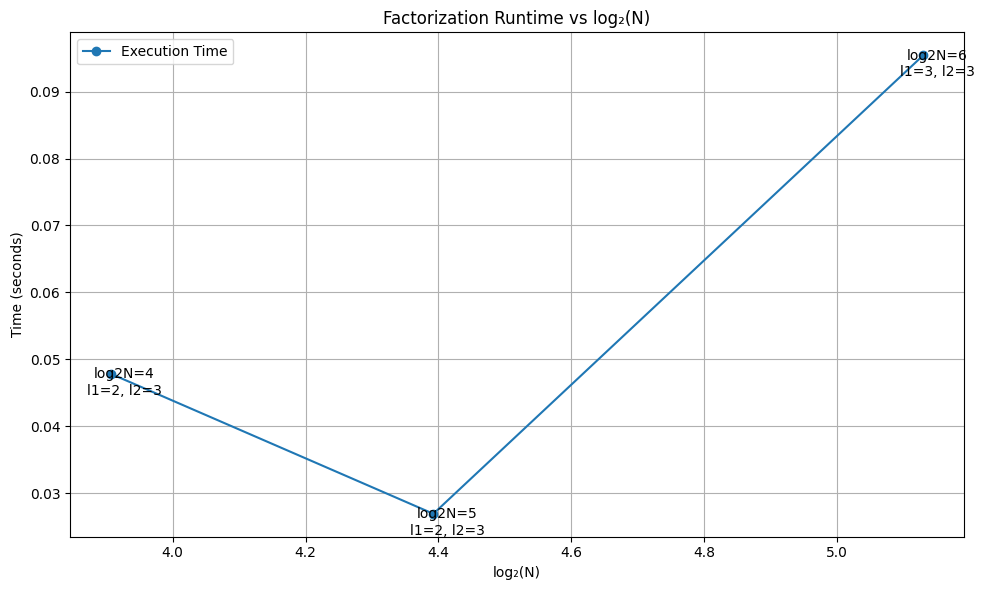

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

# timer
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# test fonction
def test_runtime(parameters):
    logN_values = []
    times = []
    
    for N, l1, l2 in parameters:
        # reset variables global
        global variables, variables_Ising, dictionaire_auxiliary_variable, res
        variables = []
        variables_Ising = []
        dictionaire_auxiliary_variable = {}
        res = 1
        
        # mesure time
        _, elapsed_time = measure_time(factorization, N, l1, l2)
        logN_values.append(np.log2(N))
        times.append(elapsed_time)
        print(f"N={N}, l1={l1}, l2={l2}: Time = {elapsed_time:.4f} sec")
    
    return logN_values, times


parameters = [(15,2,3), (21,2,3), (35,3,3), ]
#  (65,3,4),(143,4,4),(403,4,5),(899,5,50)
logN_values, times = test_runtime(parameters)

plt.figure(figsize=(10, 6))
plt.plot(logN_values, times, 'o-', label='Execution Time')
plt.xlabel('log₂(N)')
plt.ylabel('Time (seconds)')
plt.title('Factorization Runtime vs log₂(N)')
plt.grid(True)
plt.legend()

for i, (N, l1, l2) in enumerate(parameters):
    plt.annotate(f'log2N={math.ceil(math.log2(N))}\nl1={l1}, l2={l2}', 
                 (logN_values[i], times[i]),
                 textcoords="offset points",
                 xytext=(10,-15),
                 ha='center')

plt.tight_layout()
plt.show()